# Plotting eQTLs, increase font sizes

### Kynon Jade Benjamin and Apuã Paquola

In [1]:
import re
import os, errno
import functools
import numpy as np
import pandas as pd
from plotnine import *
from pandas_plink import read_plink
from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [2]:
feature = "genes"

config = {
    'biomart_file': '../_h/biomart.csv',
    'residual_expression_file': '../../_m/genes_residualized_expression.csv',
    'phenotype_file': '/ceph/projects/v4_phase3_paper/inputs/phenotypes/_m/merged_phenotypes.csv',
    'plink_file_prefix': '/ceph/projects/v4_phase3_paper/inputs/genotypes/_m/LIBD_Brain_TopMed',
    'gwas_snp_file': '/ceph/projects/v4_phase3_paper/inputs/sz_gwas/pgc2_clozuk/map_phase3/_m/libd_hg38_pgc2sz_snps_p5e_minus8.tsv',
    'mashr_file': '../../../mashr/summary_table/_m/Brainseq_LIBD_caudate_specific_4features.eGenes.txt.gz',
    'fastqtl_output_file': "/ceph/projects/v4_phase3_paper/analysis/eqtl_analysis/all/genes/"+\
        "expression_gct/prepare_expression/fastqtl_permutation/_m/Brainseq_LIBD.genes.txt.gz",
}

## Functions

### Cached preparation files

In [3]:
@functools.lru_cache()
def feature_map(feature):
    return {"genes": "Gene", "transcripts": "Transcript", 
            "exons": "Exon", "junctions": "Junction"}[feature]


@functools.lru_cache()
def get_biomart_df():
    biomart = pd.read_csv(config['biomart_file'])
    biomart['description'] = biomart['description'].str.replace('\[Source.*$','', regex=True)
    return biomart


@functools.lru_cache()
def get_residual_expression_df():
    return pd.read_csv(config['residual_expression_file'], index_col=0).transpose()


@functools.lru_cache()
def get_pheno_df():
    return pd.read_csv(config['phenotype_file'], index_col=0)


@functools.lru_cache()
def get_expression_and_pheno_df():
    return pd.merge(get_pheno_df(), get_residual_expression_df(), left_index=True, right_index=True)


@functools.lru_cache()
def get_de_df():
    """
    Load DE analysis
    """
    return pd.read_csv(config['de_file'], sep='\t', index_col=0)


@functools.lru_cache()
def get_gwas_snps():
    return pd.read_csv(config['gwas_snp_file'], sep='\t', index_col=0, low_memory=False)


@functools.lru_cache()
def get_gene_id_df():
    return pd.DataFrame({'gene_id': get_residual_expression_df().columns,
                         'ensembl_gene_id': get_residual_expression_df().columns.str.replace('\..+$','', regex=True)})


@functools.lru_cache()
def gene_info_from_symbol(gene_symbol):
    return get_biomart_df()[get_biomart_df()['external_gene_name']==gene_symbol]\
        .merge(get_gene_id_df(), on='ensembl_gene_id', how='left')


@functools.lru_cache()
def gene_id_from_symbol(gene_symbol):
    df = gene_info_from_symbol(gene_symbol)
    assert df.shape[0] == 1
    return df[['gene_id']].iloc[0].values[0]


@functools.lru_cache()
def get_plink_tuple():
    '''
    Usage: (bim, fam, bed) = get_plink_tuple()
    '''
    return read_plink(config['plink_file_prefix'])


@functools.lru_cache()
def get_caudate_eqtls():
    eqtl_df = pd.read_csv(config['mashr_file'], sep='\t')
    return eqtl_df.loc[(eqtl_df["Type"] == feature_map(feature)), ["gene_id", "variant_id"]]


@functools.lru_cache()
def get_eqtl_df():
    eqtl_df = pd.read_csv(config["fastqtl_output_file"], sep='\t')
    return eqtl_df[(eqtl_df["gene_id"].isin(get_caudate_eqtls().gene_id))]

### Variant matching

In [4]:
def get_gene_symbol(gene_id, biomart=get_biomart_df()):
    ensge = re.sub('\..+$','', gene_id)
    ggg = biomart[biomart['ensembl_gene_id']==ensge]
    if ggg.shape[0]==0:
        return '', ''
    gs = ggg['external_gene_name'].values[0]
    de = ggg['description'].values[0]
    if type(de)!=str:
        de = ''
    de = re.sub('\[Source:.*$','',de)
    return gs, de


def get_gwas_snp(snp_id):
    gwas = get_gwas_snps()
    r = gwas[gwas['our_snp_id']==snp_id]
    assert len(r) == 1
    return r


def letter_snp(number, a0, a1):
    '''
    Example:
    letter_snp(0, 'A', 'G') is 'AA'
    letter_snp(1, 'A', 'G') is 'AG'
    letter_snp(2, 'A', 'G') is 'GG'
    
    '''
    if np.isnan(number):
        return np.nan
    if len(a0)==1 and len(a1)==1:
        sep = ''
    else:
        sep = ' '
    return sep.join(sorted([a0]*int(number) + [a1]*(2-int(number))))


In [5]:
@functools.lru_cache()
def subset_bed():
    """
    This subsets the bed and bim file and returns the new subsetted
    data with shared brain_ids.
    
    This is to speed up accessing the bed file.
    """
    (bim, fam, bed) = get_plink_tuple()
    brain_ids = list(set(get_expression_and_pheno_df()['BrNum']).intersection(set(fam['fid'])))
    fam_pos = list(fam[(fam["fid"].isin(brain_ids))].drop_duplicates(subset="fid").loc[:, 'i'])
    unique_snps = get_eqtl_df().variant_id.unique()
    snp_info = bim[(bim["snp"].isin(unique_snps))].copy()
    snp_pos = list(snp_info.loc[:, "i"])
    new_bed = bed[snp_pos].compute()[:,fam_pos]
    new_bim = bim[(bim["i"].isin(snp_pos))].reset_index(drop=True)
    new_bim['ii'] = new_bim.index
    return new_bed, new_bim, brain_ids


@functools.lru_cache()
def get_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the same as in the plink files.
    
    Example: 
    get_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
    Br5168             0              GG    0\nGG
    Br2582             1              AG    1\nAG
    Br2378             1              AG    1\nAG
    Br5155             2              AA    2\nAA
    Br5182             2              AA    2\nAA
    '''
    bed, bim, brain_ids = subset_bed()
    snp_info = bim[bim['snp']==snp_id]
    snp_pos = snp_info.iloc[0]['ii']
    dfsnp = pd.DataFrame(bed[[snp_pos]], columns=brain_ids, index=[snp_id + '_num']).transpose().dropna()
    my_letter_snp = functools.partial(letter_snp, a0=snp_info.iloc[0]['a0'], a1=snp_info.iloc[0]['a1'])
    # the 2 - in next line is to workaround a possible bug in pandas_plink? a1 and a0 inverted
    dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']].astype('int')
    dfsnp[snp_id + '_letter'] = dfsnp[snp_id + '_num'].apply(my_letter_snp)
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    return dfsnp


@functools.lru_cache()
def get_gwas_ordered_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the number of risk alleles according to GWAS.
    
    Example: 
    get_gwas_ordered_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
    Br5168             2              GG    2\nGG
    Br2582             1              AG    1\nAG
    Br2378             1              AG    1\nAG
    Br5155             0              AA    0\nAA
    Br5182             0              AA    0\nAA
    '''
    pgc = get_gwas_snps()
    dfsnp = get_snp_df(snp_id).copy()
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['pgc2_a1_same_as_our_counted'].iloc[0]:
        if gwas_snp['OR'].iloc[0] > 1:
            pass
        else:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
    else:
        if gwas_snp['OR'].iloc[0] > 1:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
        else:
            pass
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    
    return dfsnp


@functools.lru_cache()
def get_risk_allele(snp_id):
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['OR'].iloc[0] > 1:
        ra = gwas_snp['A1'].iloc[0]
    else:
        ra = gwas_snp['A2'].iloc[0]
    return ra

### Plotting functions

In [6]:
def get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func):
    pheno_columns = list(get_pheno_df().columns)
    expr_df = get_expression_and_pheno_df()[pheno_columns + [gene_id]]
    snp_df =  snp_df_func(snp_id)
    return expr_df.merge(snp_df, left_on='BrNum', right_index=True)
    

def simple_snp_expression_plot_impl(snp_id, gene_id, snp_df_func):
    df = get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func)
    y0 = df[gene_id].quantile(.01) - 0.26
    y1 = df[gene_id].quantile(.99) + 0.26
    pjd = position_jitterdodge(jitter_width=0.20)
    p = ggplot(df, aes(x=snp_id, y=gene_id, fill="Region")) \
    + geom_boxplot(alpha=0.4, outlier_alpha=0) \
    + geom_jitter(position=pjd, stroke=0, alpha=0.6) + ylim(y0, y1) \
    + theme_bw(base_size=20)\
    + theme(legend_title=element_text(face='bold'), 
            panel_grid_major=element_blank(), 
            panel_grid_minor=element_blank())
    return p
    

def simple_snp_expression_plot(snp_id, gene_id):
    return simple_snp_expression_plot_impl(snp_id, gene_id, get_snp_df)


def simple_gwas_ordered_snp_expression_plot(snp_id, gene_id):
    return simple_snp_expression_plot_impl(snp_id, gene_id, get_gwas_ordered_snp_df)


def gwas_annotation(snp_id):
    return 'SZ GWAS pvalue: %.1e' % get_gwas_snp(snp_id).iloc[0]['P']


def eqtl_annotation(snp_id, gene_id):
    eqtl_df = get_eqtl_df()
    r = eqtl_df[(eqtl_df['variant_id']==snp_id) & (eqtl_df['gene_id']==gene_id)]
    assert len(r)==1
    return 'eQTL q-value: %.1e' % r.iloc[0]['qval']


def risk_allele_annotation(snp_id):
    return 'SZ risk allele: %s' % get_risk_allele(snp_id)


def annotated_eqtl_plot(snp_id, gene_id):
    p = simple_snp_expression_plot(snp_id, gene_id)
    gene_symbol, gene_description = get_gene_symbol(gene_id)
    title ="\n".join([gene_symbol,
                     eqtl_annotation(snp_id, gene_id)
                     ])
    p += ggtitle(title) + ylab('Residualized expression') 
    return p


def gwas_annotated_eqtl_plot(snp_id, gene_id):
    p = simple_gwas_ordered_snp_expression_plot(snp_id, gene_id)
    gene_symbol, gene_description = get_gene_symbol(gene_id)
    title ="\n".join([gene_symbol,
                     eqtl_annotation(snp_id, gene_id),
                     gwas_annotation(snp_id),
                     risk_allele_annotation(snp_id)
                     ])
    p += ggtitle(title) + ylab('Residualized expression') 
    return p


def save_plot(p, fn):
    for ext in ['png', 'pdf', 'svg']:
        p.save(fn + '.' + ext)
    

# Top 10 eQTLs

In [7]:
eqtl_df = get_eqtl_df()
eqtl_df.shape

(1932, 19)

In [8]:
top_10 = eqtl_df.sort_values('pval_nominal', ascending=True).head(10).reset_index(drop=True)
top_10

,gene_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,ma_count,maf,ref_factor,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold
0,ENSG00000080644.15,4093,1.02864,537.302,356.264,6.906470e-105,chr15:78626420:G:C,5125,201,234,0.264108,1,1.455720e-119,1.168930,0.034756,0.0001,4.562650e-105,6.626210e-103,0.000322
1,ENSG00000197943.9,5911,1.04611,1037.640,361.232,2.332940e-86,chr16:81842764:G:C,103667,172,194,0.218962,1,4.526160e-97,1.209810,0.043157,0.0001,3.679540e-87,2.353770e-85,0.000174
2,ENSG00000037280.15,5072,1.03289,736.139,356.145,5.024500e-60,chr5:180616731:C:A,-32893,176,197,0.222348,1,2.406380e-68,-1.085970,0.050895,0.0001,5.077320e-59,9.849280e-58,0.000237
3,ENSG00000228203.6,4228,1.04032,649.263,357.933,5.648010e-60,chr2:6980350:G:T,61641,195,236,0.266366,1,5.913000e-68,-0.731495,0.034426,0.0001,1.910160e-59,3.732390e-58,0.000274
4,ENSG00000133665.12,5159,1.05556,440.568,341.379,6.169420e-54,chr10:80356846:G:A,12101,265,322,0.363431,-1,5.730920e-64,-0.614527,0.030212,0.0001,4.113580e-54,6.520340e-53,0.000418
5,ENSG00000113494.16,4082,1.05987,406.859,345.553,7.707640e-54,chr5:35199555:A:C,-31034,323,423,0.477427,-1,4.201840e-63,0.656903,0.032612,0.0001,2.891440e-54,4.610350e-53,0.000457
6,ENSG00000165495.15,3920,1.06587,574.697,353.323,1.176020e-53,chr11:125240270:C:T,75583,150,166,0.187359,1,1.527530e-61,0.918283,0.046407,0.0001,3.255700e-54,5.175800e-53,0.000328
7,ENSG00000163866.8,3525,1.04414,502.125,358.172,3.397760e-54,chr1:34732965:A:G,-126851,309,394,0.444695,-1,2.404120e-61,-0.691393,0.035020,0.0001,9.606340e-54,1.504920e-52,0.000357
8,ENSG00000164597.13,3342,1.04887,350.850,349.666,4.696970e-49,chr7:107510756:C:A,-53758,106,116,0.130926,1,8.171420e-57,1.096400,0.058600,0.0001,9.334340e-49,1.171900e-47,0.000517
9,ENSG00000161381.13,3186,1.05164,393.699,350.720,6.533590e-47,chr17:39074161:C:G,-80233,266,342,0.386005,-1,3.662940e-54,-0.624122,0.034474,0.0001,1.411060e-46,1.586230e-45,0.000463


Mapping files: 100%|██████████| 3/3 [00:26<00:00,  8.74s/it]


top_0_eqtl_caudate 0 chr15:78626420:G:C ENSG00000080644.15


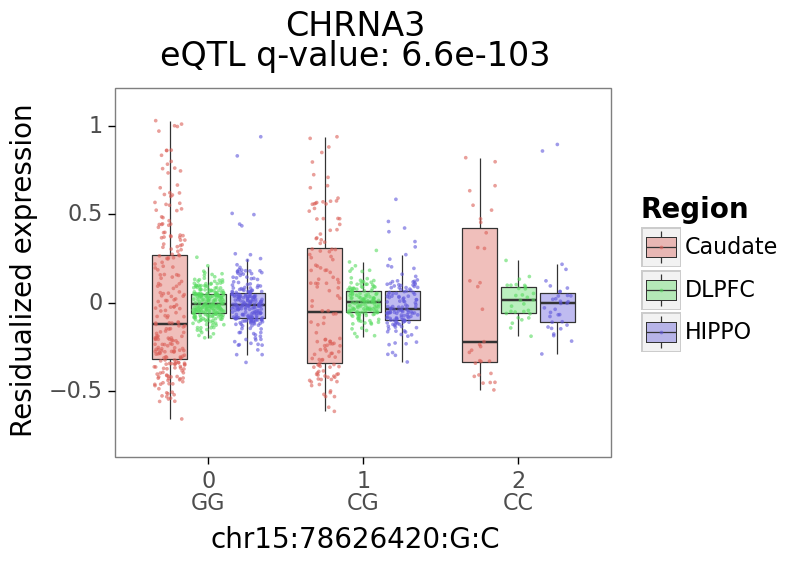

<ggplot: (8765091720837)>
top_1_eqtl_caudate 1 chr16:81842764:G:C ENSG00000197943.9


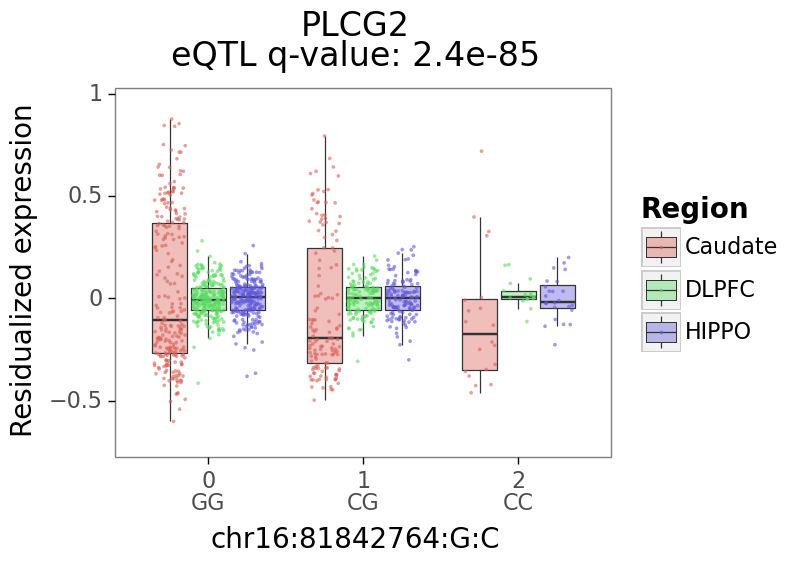

<ggplot: (8765065361713)>
top_2_eqtl_caudate 2 chr5:180616731:C:A ENSG00000037280.15


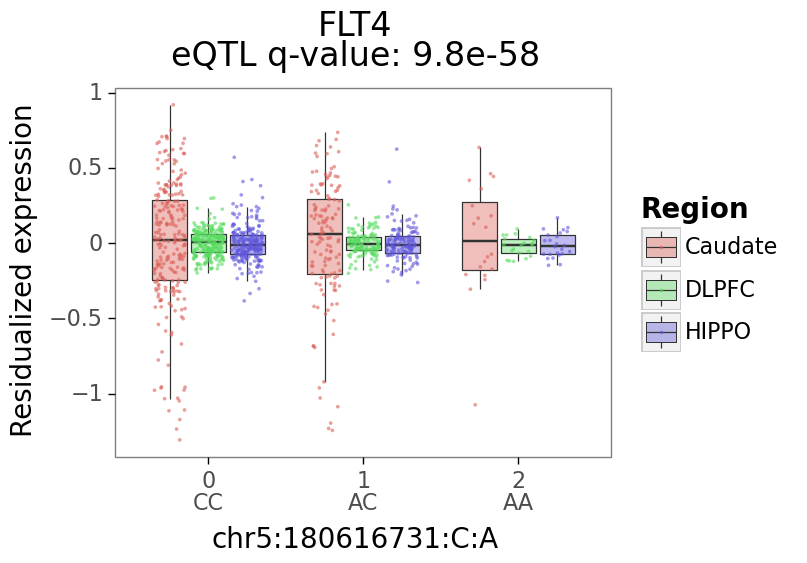

<ggplot: (8765065108565)>
top_3_eqtl_caudate 3 chr2:6980350:G:T ENSG00000228203.6


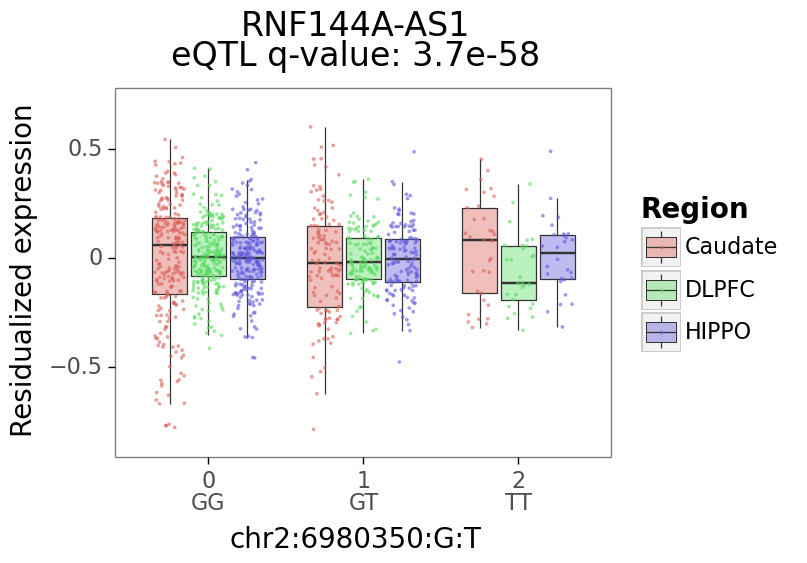

<ggplot: (8765064137906)>
top_4_eqtl_caudate 4 chr10:80356846:G:A ENSG00000133665.12


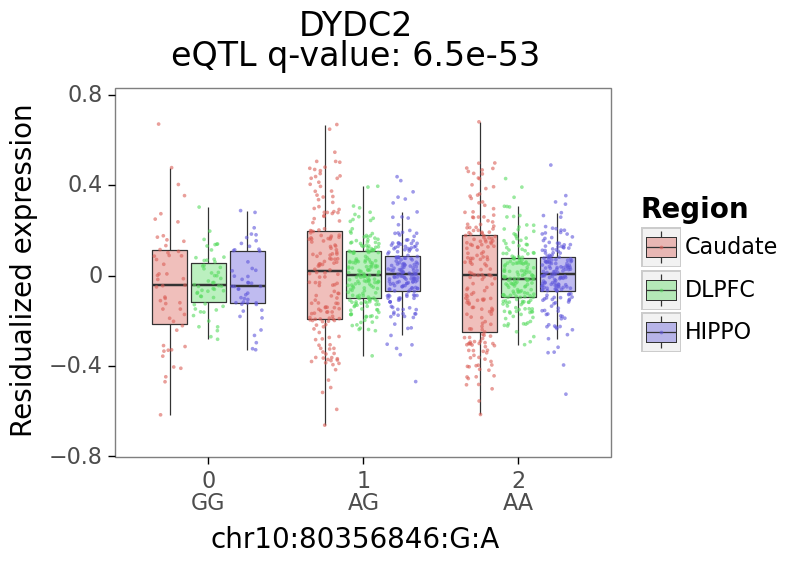

<ggplot: (8765044875042)>
top_5_eqtl_caudate 5 chr5:35199555:A:C ENSG00000113494.16


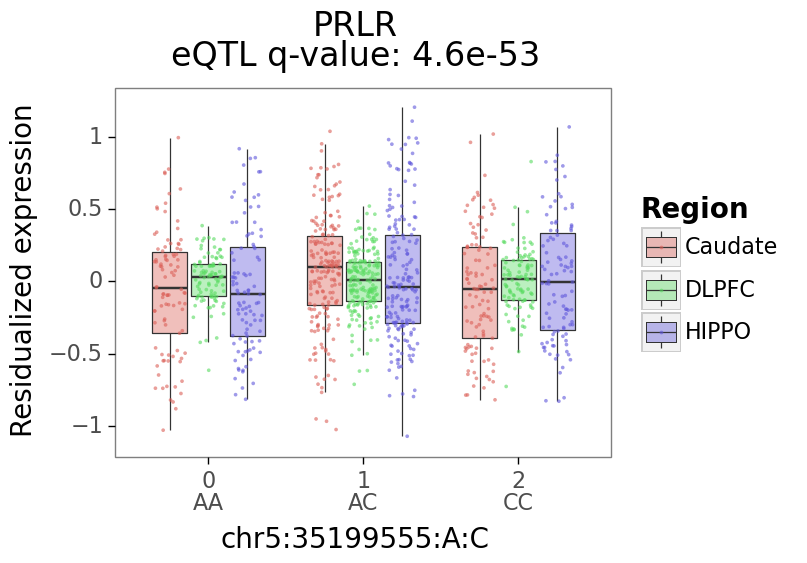

<ggplot: (8765044149294)>
top_6_eqtl_caudate 6 chr11:125240270:C:T ENSG00000165495.15


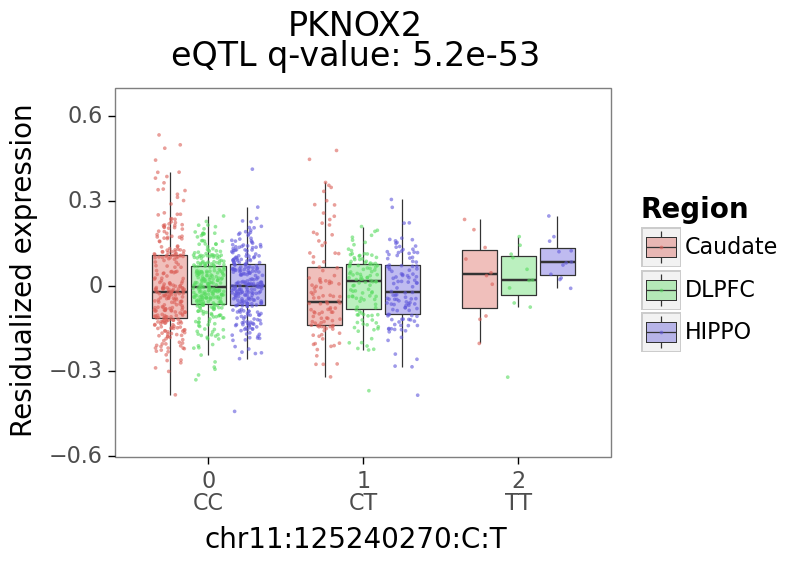

<ggplot: (8765064781909)>
top_7_eqtl_caudate 7 chr1:34732965:A:G ENSG00000163866.8


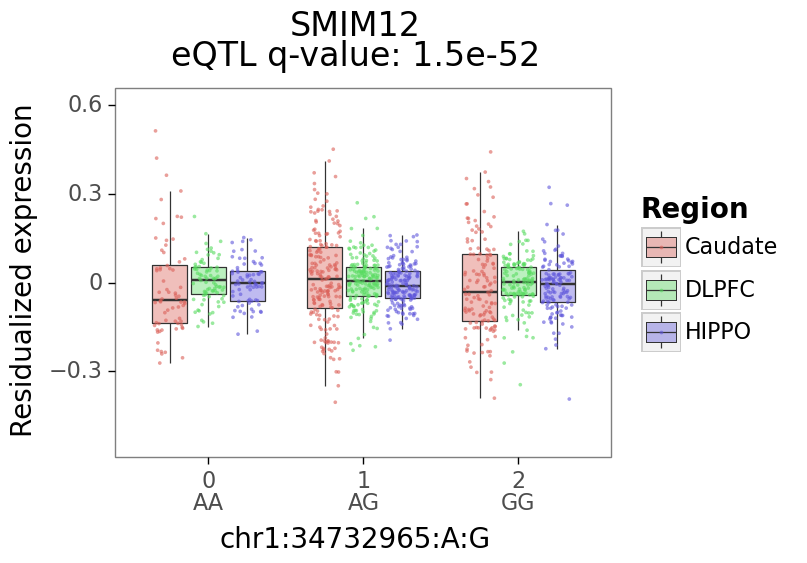

<ggplot: (8765043240141)>
top_8_eqtl_caudate 8 chr7:107510756:C:A ENSG00000164597.13


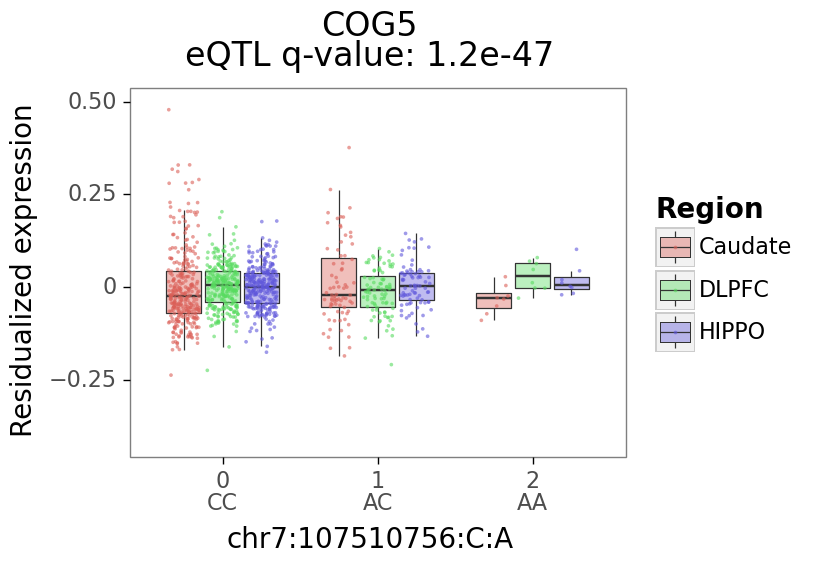

<ggplot: (8765064842722)>
top_9_eqtl_caudate 9 chr17:39074161:C:G ENSG00000161381.13


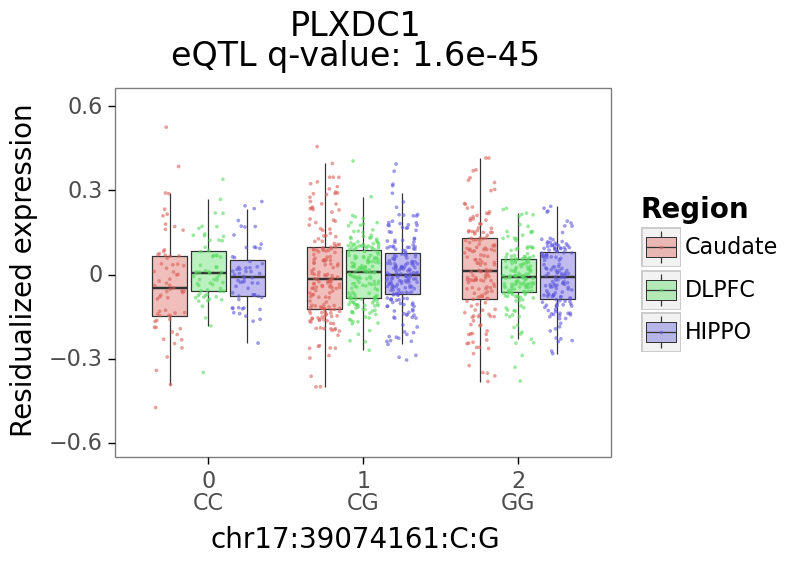

<ggplot: (8765045309648)>


In [9]:
for x in top_10.itertuples():
    filename = "top_%d_eqtl_caudate" % x.Index
    p = annotated_eqtl_plot(x.variant_id, x.gene_id)
    print(filename, x.Index, x.variant_id, x.gene_id)
    print(p)
    save_plot(p, filename)
    

# Top 10 eQTL with GWAS significant variants

In [11]:
gwas_eqtl_df = eqtl_df.merge(get_gwas_snps(), left_on = 'variant_id', 
                             right_on = 'our_snp_id', suffixes=['','_gwas'])
print(gwas_eqtl_df.shape)
gwas_eqtl_df

(11, 41)


,gene_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,ma_count,...,A2,OR,SE,P,hg19chrc,hg38chrc,hg38pos,pgc2_a1_same_as_our_counted,rsid,is_index_snp
0,ENSG00000196141.13,2786,1.05379,279.328,342.850,2.178200e-05,chr2:200299060:A:G,-6821,151,169,...,G,0.93628,0.010137,8.280000e-11,chr2,chr2,200299060,False,rs4673905,False
1,ENSG00000205981.6,2450,1.03103,198.695,357.039,6.537590e-04,chr3:181110020:A:G,120246,128,141,...,G,1.07810,0.012039,4.300000e-10,chr3,chr3,181110020,False,rs35212830,False
2,ENSG00000249484.8,4168,1.02535,326.601,351.574,5.529070e-16,chr5:152894716:G:A,-328827,309,413,...,A,0.94418,0.009860,5.710000e-09,chr5,chr5,152894716,False,rs13188558,False
3,ENSG00000124610.4,3966,1.04661,215.630,334.185,4.987160e-05,chr6:26090224:T:C,72492,255,318,...,C,1.08390,0.010905,1.500000e-13,chr6,chr6,26090224,False,rs13196986,False
4,ENSG00000204386.10,6118,1.07446,234.419,321.685,4.946900e-04,chr6:31701719:C:T,-161187,50,53,...,T,0.90618,0.017514,1.850000e-08,chr6,chr6,31701719,False,rs1266071,False
5,ENSG00000204371.11,5739,1.06250,242.393,324.467,5.559410e-22,chr6:31910718:A:G,13031,142,165,...,G,0.91962,0.010718,5.340000e-15,chr6,chr6,31910718,False,rs622871,False
6,ENSG00000150967.17,2892,1.04212,200.899,338.080,2.801550e-05,chr12:122966218:G:C,-15431,192,219,...,C,1.06950,0.011581,6.590000e-09,chr12,chr12,122966218,False,rs4148856,False
7,ENSG00000088808.16,4249,1.06500,394.626,344.221,1.314530e-31,chr14:103756555:C:T,-91035,213,255,...,T,0.93151,0.010063,1.790000e-12,chr14,chr14,103756555,False,rs12886637,False
8,ENSG00000174938.14,1592,1.06550,228.280,346.685,2.127980e-06,chr16:29961369:C:T,61822,263,315,...,T,1.06950,0.009638,3.060000e-12,chr16,chr16,29961369,False,rs4788201,False
9,ENSG00000149930.17,1637,1.03636,253.345,354.893,1.843360e-08,chr16:29971163:G:A,-2478,241,287,...,A,1.07000,0.009638,2.230000e-12,chr16,chr16,29971163,False,rs12445982,False


In [13]:
top_gwas_eqtl_df = gwas_eqtl_df[(gwas_eqtl_df['P']<5e-8) & 
                                (gwas_eqtl_df['is_index_snp'])].sort_values(['pval_nominal', 'P'])
print(top_gwas_eqtl_df.shape)
top_gwas_eqtl_df.head()

(0, 41)


,gene_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,ma_count,...,A2,OR,SE,P,hg19chrc,hg38chrc,hg38pos,pgc2_a1_same_as_our_counted,rsid,is_index_snp


In [16]:
top_gwas_eqtl_df = gwas_eqtl_df.sort_values(['pval_nominal', 'P'])
print(top_gwas_eqtl_df.shape)
top_gwas_eqtl_df

(11, 41)


,gene_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,ma_count,...,A2,OR,SE,P,hg19chrc,hg38chrc,hg38pos,pgc2_a1_same_as_our_counted,rsid,is_index_snp
7,ENSG00000088808.16,4249,1.06500,394.626,344.221,1.314530e-31,chr14:103756555:C:T,-91035,213,255,...,T,0.93151,0.010063,1.790000e-12,chr14,chr14,103756555,False,rs12886637,False
5,ENSG00000204371.11,5739,1.06250,242.393,324.467,5.559410e-22,chr6:31910718:A:G,13031,142,165,...,G,0.91962,0.010718,5.340000e-15,chr6,chr6,31910718,False,rs622871,False
2,ENSG00000249484.8,4168,1.02535,326.601,351.574,5.529070e-16,chr5:152894716:G:A,-328827,309,413,...,A,0.94418,0.009860,5.710000e-09,chr5,chr5,152894716,False,rs13188558,False
9,ENSG00000149930.17,1637,1.03636,253.345,354.893,1.843360e-08,chr16:29971163:G:A,-2478,241,287,...,A,1.07000,0.009638,2.230000e-12,chr16,chr16,29971163,False,rs12445982,False
8,ENSG00000174938.14,1592,1.06550,228.280,346.685,2.127980e-06,chr16:29961369:C:T,61822,263,315,...,T,1.06950,0.009638,3.060000e-12,chr16,chr16,29961369,False,rs4788201,False
0,ENSG00000196141.13,2786,1.05379,279.328,342.850,2.178200e-05,chr2:200299060:A:G,-6821,151,169,...,G,0.93628,0.010137,8.280000e-11,chr2,chr2,200299060,False,rs4673905,False
6,ENSG00000150967.17,2892,1.04212,200.899,338.080,2.801550e-05,chr12:122966218:G:C,-15431,192,219,...,C,1.06950,0.011581,6.590000e-09,chr12,chr12,122966218,False,rs4148856,False
3,ENSG00000124610.4,3966,1.04661,215.630,334.185,4.987160e-05,chr6:26090224:T:C,72492,255,318,...,C,1.08390,0.010905,1.500000e-13,chr6,chr6,26090224,False,rs13196986,False
4,ENSG00000204386.10,6118,1.07446,234.419,321.685,4.946900e-04,chr6:31701719:C:T,-161187,50,53,...,T,0.90618,0.017514,1.850000e-08,chr6,chr6,31701719,False,rs1266071,False
10,ENSG00000213790.2,3744,1.06409,311.781,340.147,4.350070e-04,chr22:42070946:C:T,-38007,265,325,...,T,0.94112,0.010193,2.620000e-09,chr22,chr22,42070946,False,rs133377,False


top_0_eqtl_in_gwas_significant_caudate 0 chr14:103756555:C:T ENSG00000088808.16


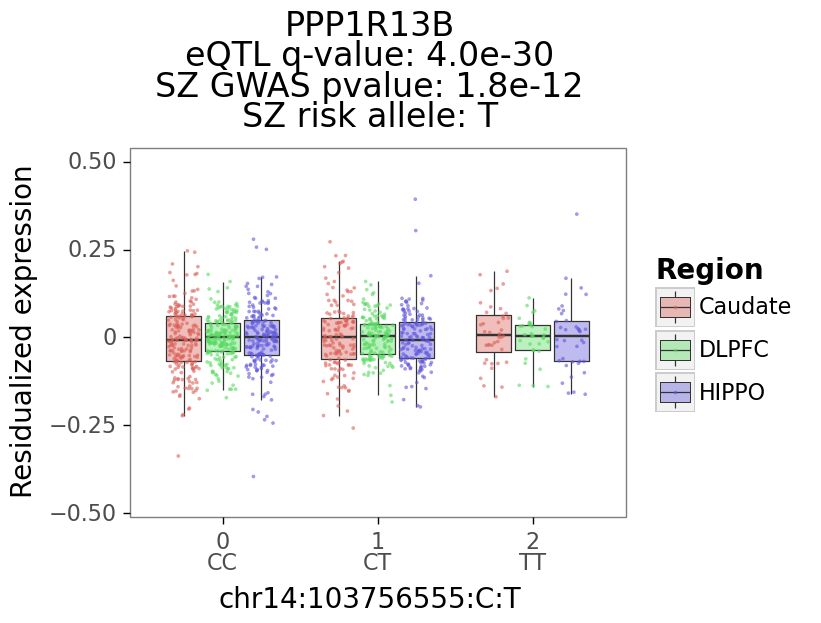

<ggplot: (8765042776411)>
top_1_eqtl_in_gwas_significant_caudate 1 chr6:31910718:A:G ENSG00000204371.11


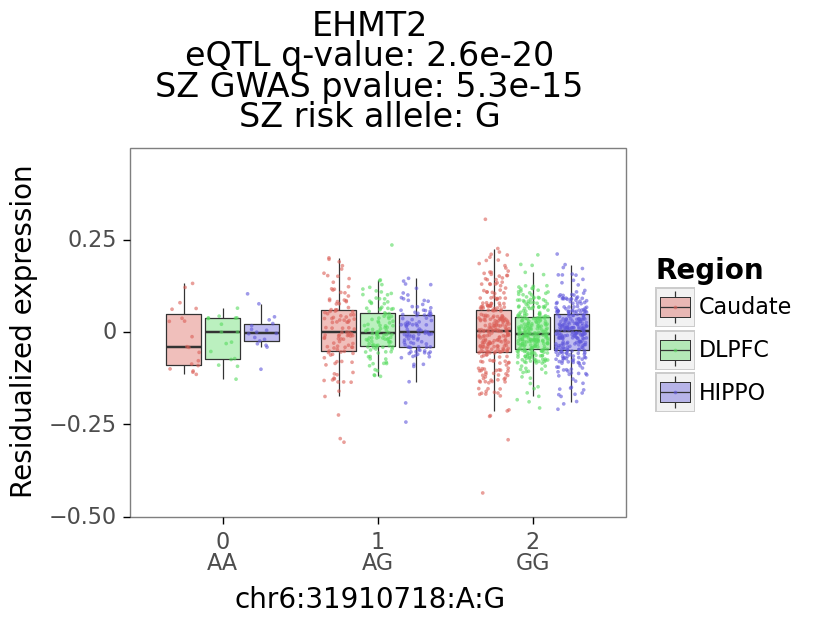

<ggplot: (8765064966160)>
top_2_eqtl_in_gwas_significant_caudate 2 chr5:152894716:G:A ENSG00000249484.8


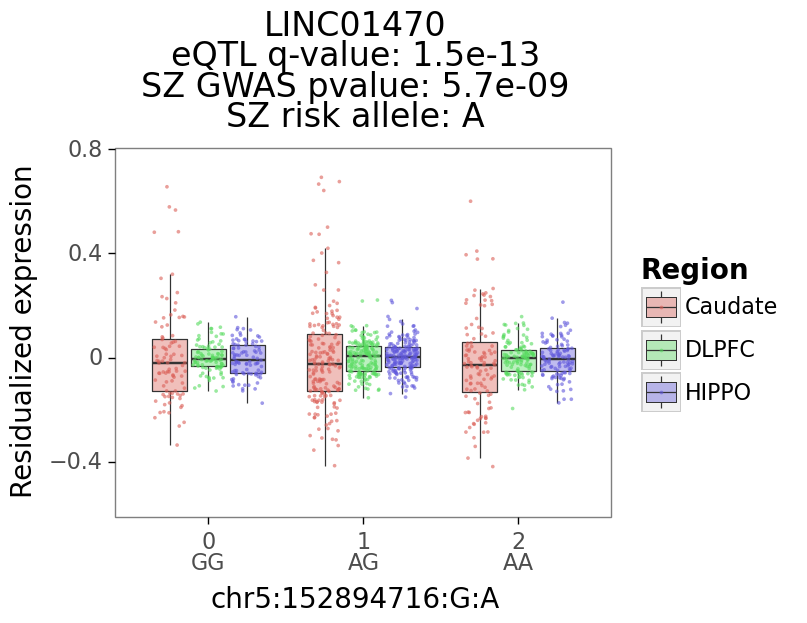

<ggplot: (8765043670266)>
top_3_eqtl_in_gwas_significant_caudate 3 chr16:29971163:G:A ENSG00000149930.17


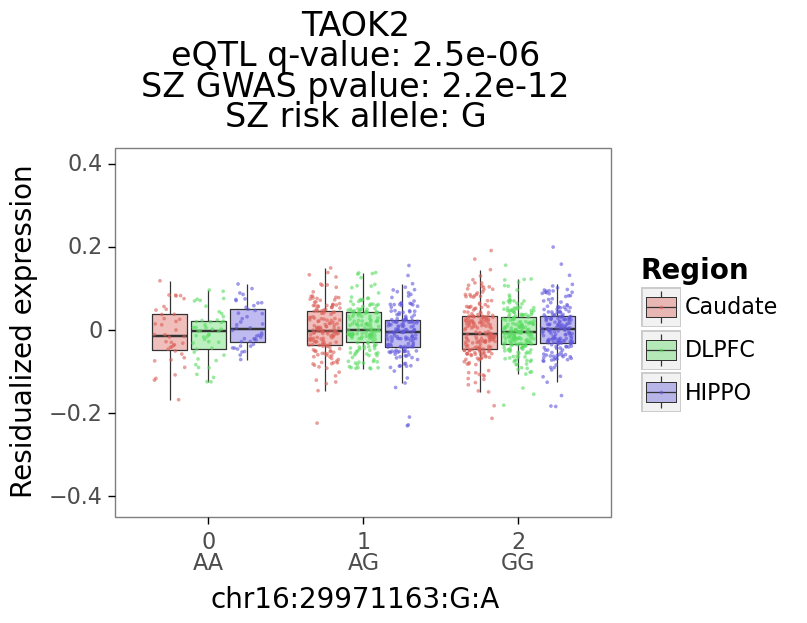

<ggplot: (8765044798224)>
top_4_eqtl_in_gwas_significant_caudate 4 chr16:29961369:C:T ENSG00000174938.14


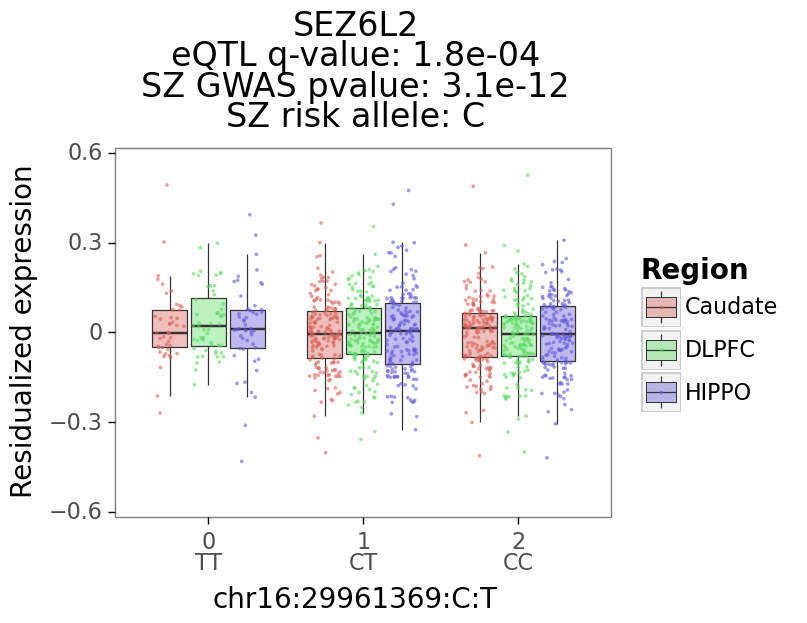

<ggplot: (8765064627155)>
top_5_eqtl_in_gwas_significant_caudate 5 chr2:200299060:A:G ENSG00000196141.13


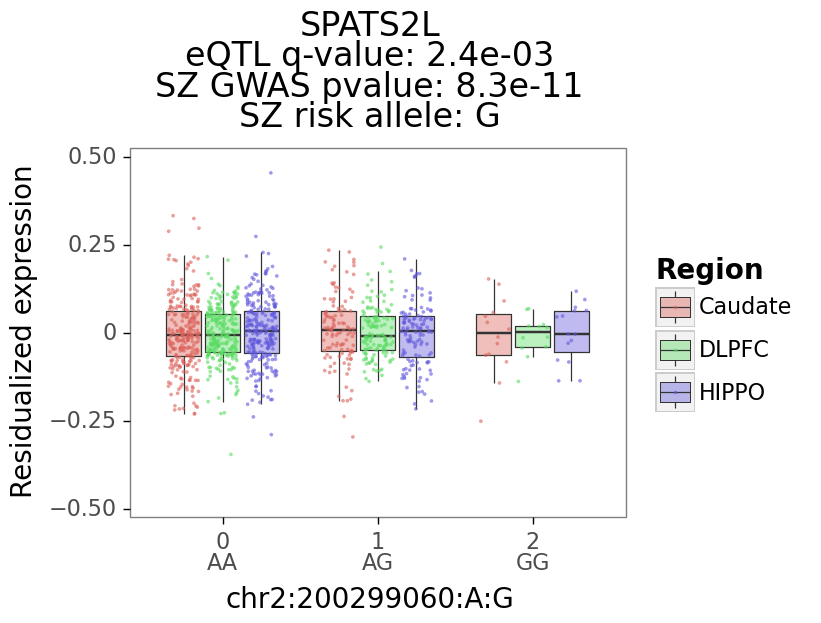

<ggplot: (8765025852983)>
top_6_eqtl_in_gwas_significant_caudate 6 chr12:122966218:G:C ENSG00000150967.17


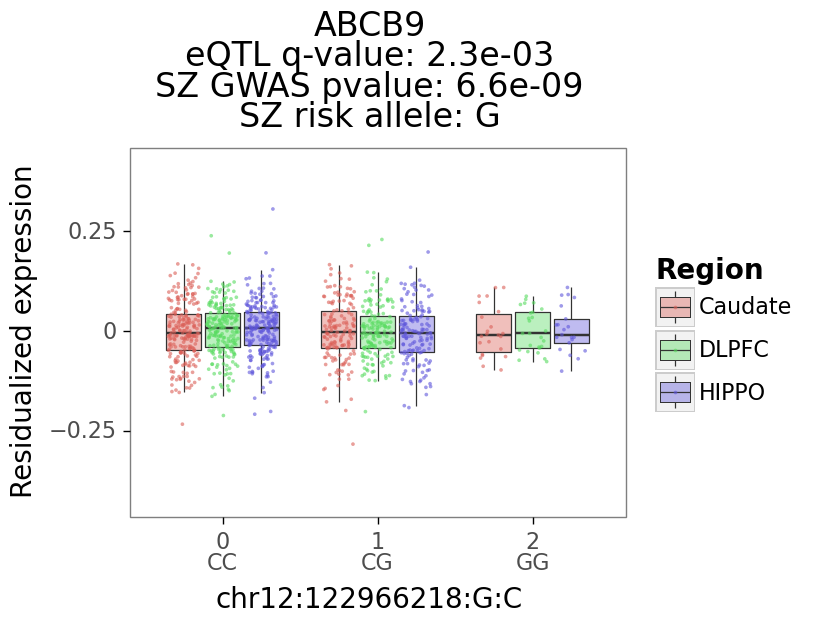

<ggplot: (8765064528195)>
top_7_eqtl_in_gwas_significant_caudate 7 chr6:26090224:T:C ENSG00000124610.4


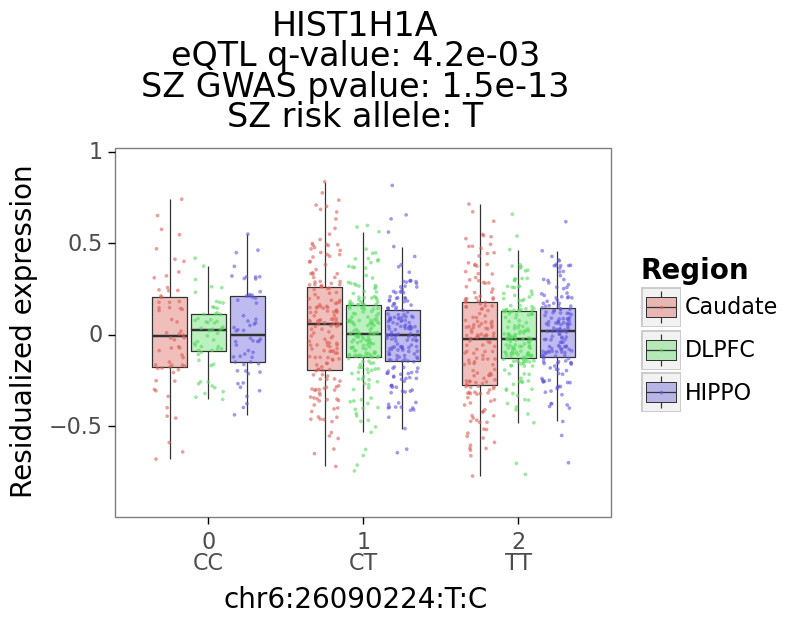

<ggplot: (8765063873774)>
top_8_eqtl_in_gwas_significant_caudate 8 chr6:31701719:C:T ENSG00000204386.10


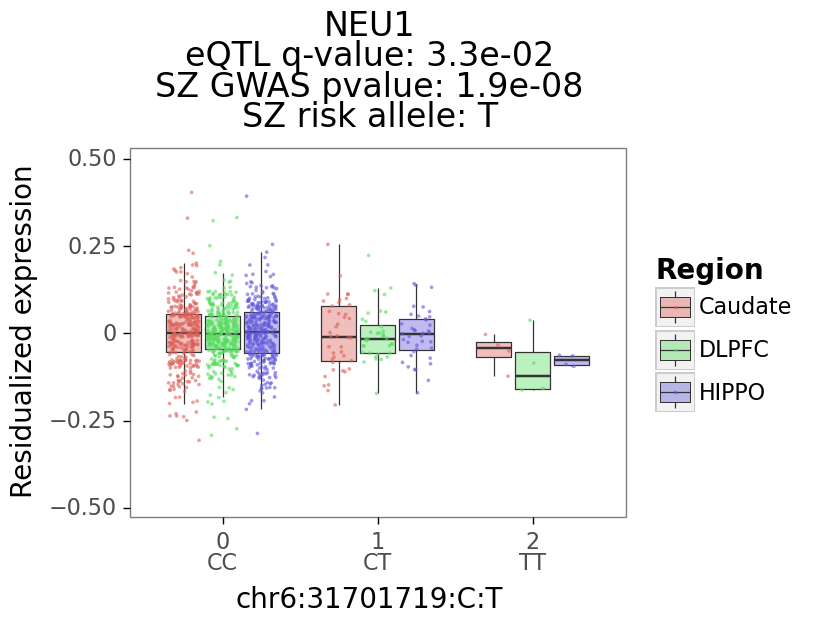

<ggplot: (8765043055041)>
top_9_eqtl_in_gwas_significant_caudate 9 chr22:42070946:C:T ENSG00000213790.2


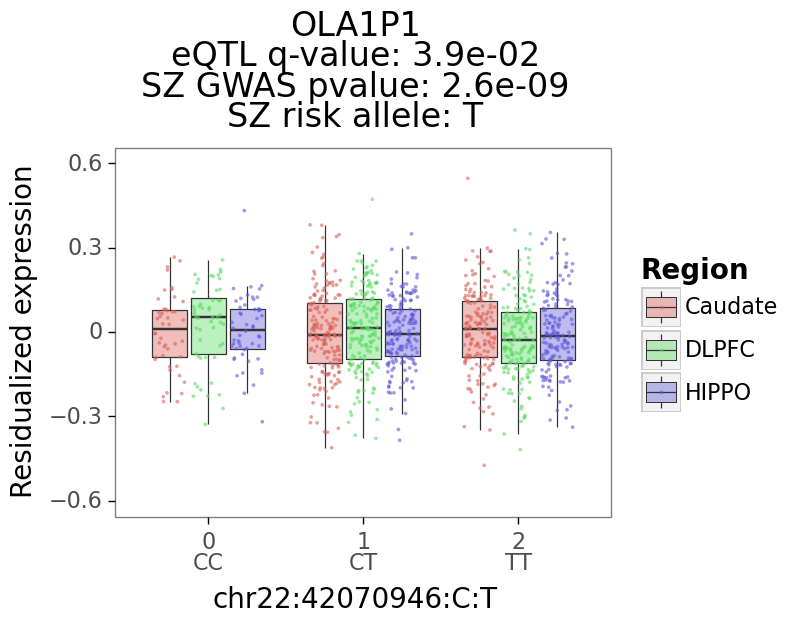

<ggplot: (8765063962673)>
top_10_eqtl_in_gwas_significant_caudate 10 chr3:181110020:A:G ENSG00000205981.6


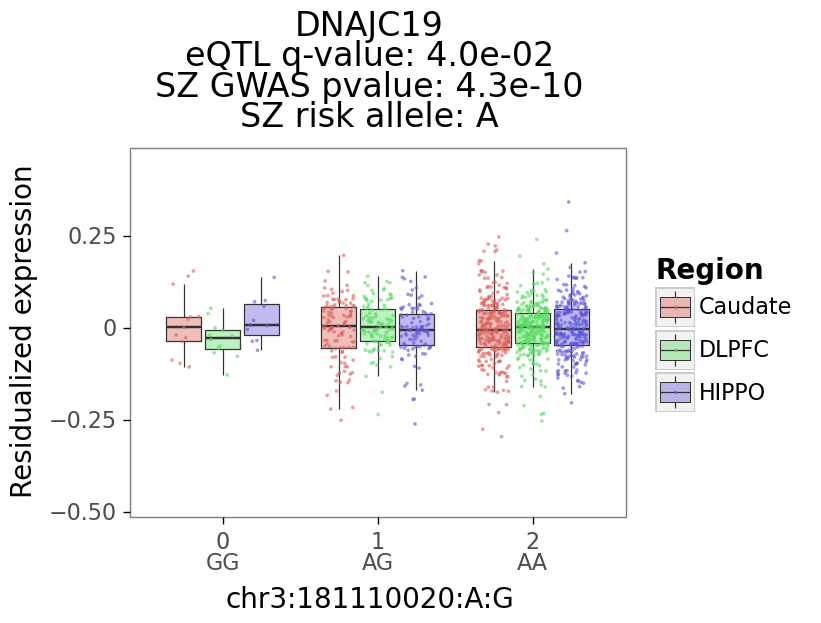

<ggplot: (8765038198932)>


In [17]:
top10 = top_gwas_eqtl_df.reset_index()
for x  in top10.itertuples():
    filename = "top_%d_eqtl_in_gwas_significant_caudate" % x.Index
    p = gwas_annotated_eqtl_plot(x.variant_id, x.gene_id)
    print(filename, x.Index, x.variant_id, x.gene_id)
    print(p)
    save_plot(p, filename)